In [2]:
!pip install factor_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 47.5 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.4.1-py2.py3-none-any.whl size=42034 sha256=28a734b51bbea5ece5d7368ca449bdcf0aac783bd02d78e3a88040fc949300af
  Stored in directory: /root/.cache/pip/wheels/6d/32/bd/460a71becd83f7d77152f437c2fd451f5c87bc19cfcdbfcd24
Successfully built factor_analyzer


In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn.decomposition import PCA

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD, Adam

%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: <object object at 0x7f992d005160>
Populating the interactive namespace from numpy and matplotlib


In [5]:
forbes = pd.read_csv("/content/forbes12.csv")

forbes.head()

,rank,personName,age,finalWorth,year,month,category,source,country,state,...,selfMade,gender,birthDate,title,philanthropyScore,residenceMsa,numberOfSiblings,bio,about,Unnamed: 22
0,1,Elon Musk,50.0,219000.0,2022,4,Automotive,"Tesla, SpaceX",United States,Texas,...,True,M,1971-06-28,CEO,1.0,NaN,NaN,Elon Musk is working to revolutionize transpor...,Musk was accepted to a graduate program at Sta...,NaN
1,2,Jeff Bezos,58.0,171000.0,2022,4,Technology,Amazon,United States,Washington,...,True,M,1964-01-12,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,Jeff Bezos founded e-commerce giant Amazon in ...,"Growing up, Jeff Bezos worked summers on his g...",NaN
2,3,Bernard Arnault & family,73.0,158000.0,2022,4,Fashion & Retail,LVMH,France,NaN,...,False,M,1949-03-05,Chairman and CEO,NaN,NaN,NaN,Bernard Arnault oversees the LVMH empire of so...,"Arnault apparently wooed his wife, Helene Merc...",NaN
3,4,Bill Gates,66.0,129000.0,2022,4,Technology,Microsoft,United States,Washington,...,True,M,1955-10-28,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,Bill Gates turned his fortune from software fi...,"When Gates was a kid, he spent so much time re...",NaN
4,5,Warren Buffett,91.0,118000.0,2022,4,Finance & Investments,Berkshire Hathaway,United States,Nebraska,...,True,M,1930-08-30,CEO,5.0,"Omaha, NE",NaN,"Known as the ""Oracle of Omaha,"" Warren Buffett...","Buffett still lives in the same Omaha, Nebrask...",NaN


In [6]:
forbes.columns

Index(['rank', 'personName', 'age', 'finalWorth', 'year', 'month', 'category',
       'source', 'country', 'state', 'city', 'countryOfCitizenship',
       'organization', 'selfMade', 'gender', 'birthDate', 'title',
       'philanthropyScore', 'residenceMsa', 'numberOfSiblings', 'bio', 'about',
       'Unnamed: 22'],
      dtype='object')

In [7]:
forbes.drop(columns=['rank', 'personName', 'year', 'month', 'birthDate', 'bio', 'about'], inplace=True)
forbes.shape

(365, 16)

In [8]:
nan_gender = forbes[~forbes['gender'].isin(['M', 'F'])]

len(nan_gender)

6

In [9]:
forbes.drop(nan_gender.index, inplace=True)

In [10]:
forbes['gender'].unique()

array(['M', 'F'], dtype=object)

In [11]:
cat_cols = forbes.select_dtypes(include="object").columns

cat_cols

Index(['category', 'source', 'country', 'state', 'city',
       'countryOfCitizenship', 'organization', 'gender', 'title',
       'residenceMsa', 'Unnamed: 22'],
      dtype='object')

In [12]:
for col in cat_cols:
  forbes[col] = pd.Categorical(forbes[col])

forbes.dtypes

age                      float64
finalWorth               float64
category                category
source                  category
country                 category
state                   category
city                    category
countryOfCitizenship    category
organization            category
selfMade                    bool
gender                  category
title                   category
philanthropyScore        float64
residenceMsa            category
numberOfSiblings         float64
Unnamed: 22             category
dtype: object

In [13]:
gender_dummy = pd.get_dummies(forbes['gender'], prefix='gender')

forbes = pd.concat([forbes, gender_dummy], axis=1)

forbes.iloc[:, 10:].head()

,gender,title,philanthropyScore,residenceMsa,numberOfSiblings,Unnamed: 22,gender_F,gender_M
0,M,CEO,1.0,NaN,NaN,NaN,0,1
1,M,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
2,M,Chairman and CEO,NaN,NaN,NaN,NaN,0,1
3,M,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
4,M,CEO,5.0,"Omaha, NE",NaN,NaN,0,1


In [14]:
forbes.drop(columns=['gender'], inplace=True)

forbes.iloc[:, 6:].head()

,city,countryOfCitizenship,organization,selfMade,title,philanthropyScore,residenceMsa,numberOfSiblings,Unnamed: 22,gender_F,gender_M
0,Austin,United States,Tesla,True,CEO,1.0,NaN,NaN,NaN,0,1
1,Seattle,United States,Amazon,True,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
2,Paris,France,LVMH Moët Hennessy Louis Vuitton,False,Chairman and CEO,NaN,NaN,NaN,NaN,0,1
3,Medina,United States,Bill & Melinda Gates Foundation,True,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,NaN,0,1
4,Omaha,United States,Berkshire Hathaway,True,CEO,5.0,"Omaha, NE",NaN,NaN,0,1


In [15]:
forbes['category'] = forbes['category'].cat.codes

forbes['category'].head()

0     0
1    16
2     4
3    16
4     5
Name: category, dtype: int8

In [16]:
label_encoder = LabelEncoder()

forbes['country'] = label_encoder.fit_transform(forbes['country'])

forbes['country'].head()

0    36
1    36
2    12
3    36
4    36
Name: country, dtype: int64

In [17]:
cat_cols_ = forbes.select_dtypes(exclude=['number']).columns

for col in cat_cols_:
  forbes[col] = label_encoder.fit_transform(forbes[col])

forbes.dtypes

age                     float64
finalWorth              float64
category                   int8
source                    int64
country                   int64
state                     int64
city                      int64
countryOfCitizenship      int64
organization              int64
selfMade                  int64
title                     int64
philanthropyScore       float64
residenceMsa              int64
numberOfSiblings        float64
Unnamed: 22               int64
gender_F                  uint8
gender_M                  uint8
dtype: object

In [18]:
forbes.isnull().sum() / forbes.shape[0] * 100

age                      1.671309
finalWorth               0.000000
category                 0.000000
source                   0.000000
country                  0.000000
state                    0.000000
city                     0.000000
countryOfCitizenship     0.000000
organization             0.000000
selfMade                 0.000000
title                    0.000000
philanthropyScore       71.309192
residenceMsa             0.000000
numberOfSiblings        94.707521
Unnamed: 22              0.000000
gender_F                 0.000000
gender_M                 0.000000
dtype: float64

In [19]:
forbes.dropna(axis=1, thresh=forbes.shape[0]*0.5, how='all', inplace=True)

forbes.isnull().sum() / forbes.shape[0] * 100

age                     1.671309
finalWorth              0.000000
category                0.000000
source                  0.000000
country                 0.000000
state                   0.000000
city                    0.000000
countryOfCitizenship    0.000000
organization            0.000000
selfMade                0.000000
title                   0.000000
residenceMsa            0.000000
Unnamed: 22             0.000000
gender_F                0.000000
gender_M                0.000000
dtype: float64

In [20]:
mean_age = float(int(forbes['age'].mean()))
forbes['age'].fillna(mean_age, inplace=True)

forbes.isnull().sum()

age                     0
finalWorth              0
category                0
source                  0
country                 0
state                   0
city                    0
countryOfCitizenship    0
organization            0
selfMade                0
title                   0
residenceMsa            0
Unnamed: 22             0
gender_F                0
gender_M                0
dtype: int64

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

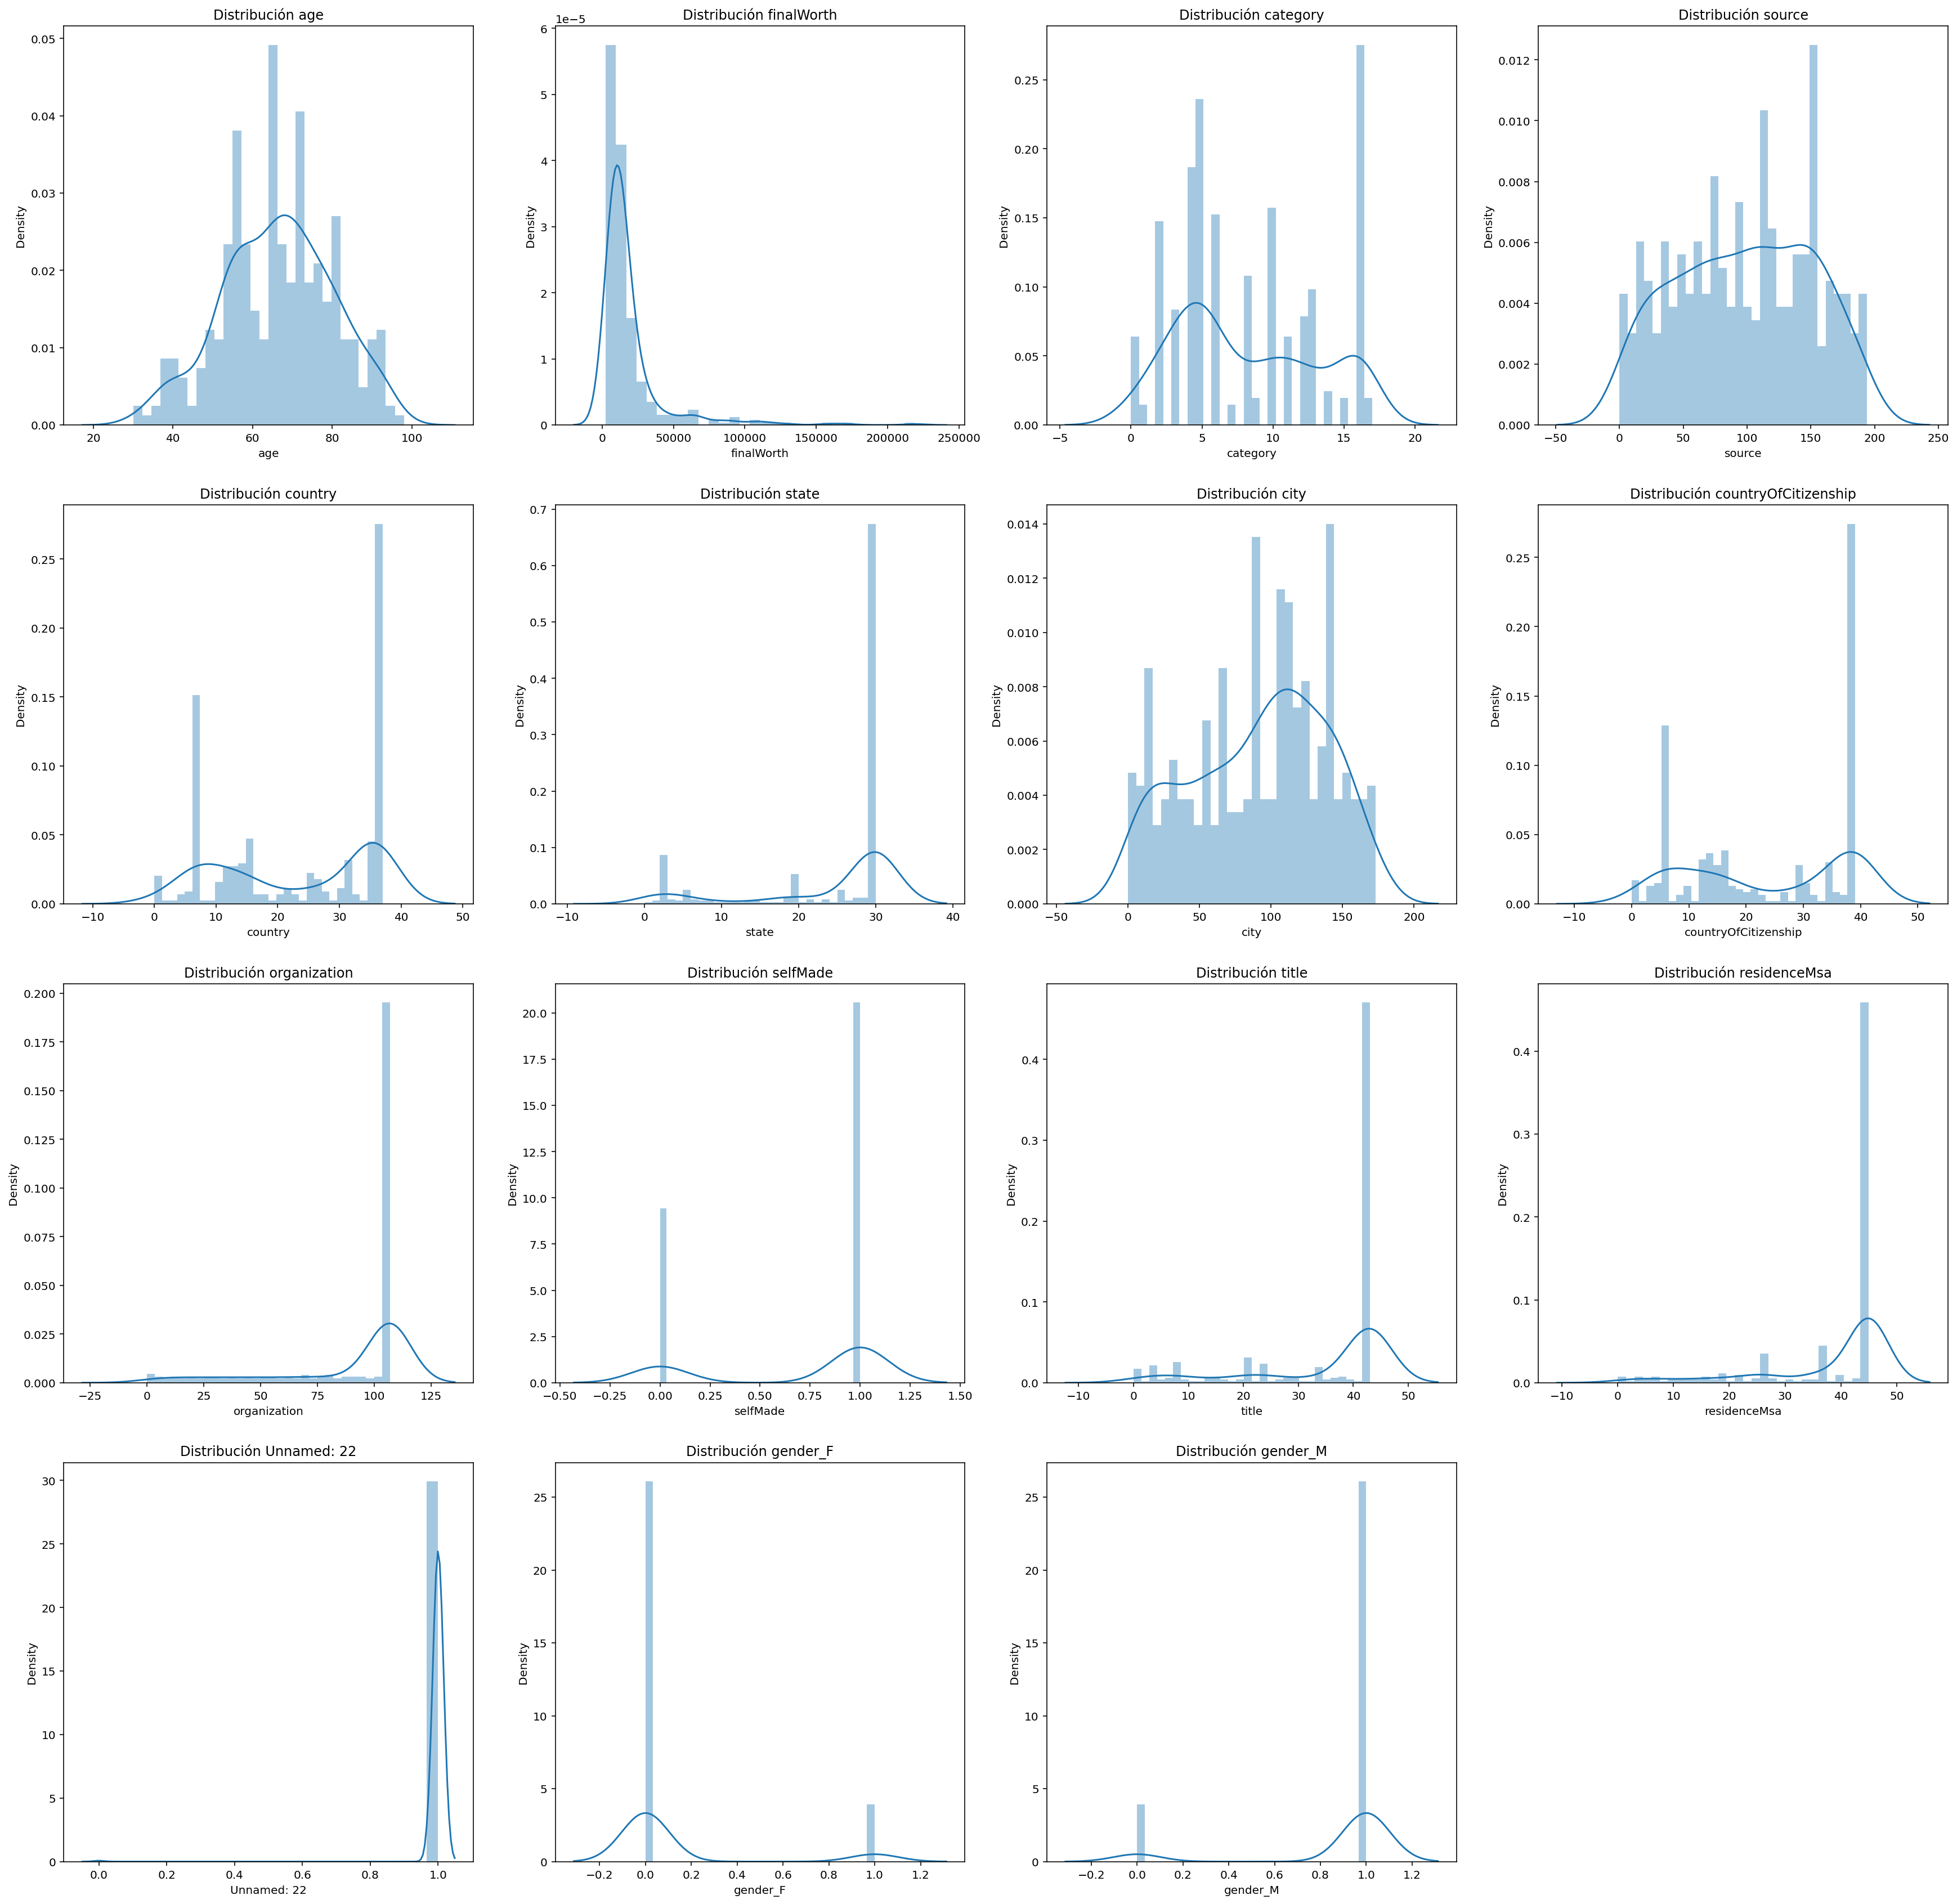

In [21]:
plt.figure(figsize=(30, 30))
n = 0
for i, column in enumerate(forbes.columns):
    n += 1
    plt.subplot(4, 4, n)
    try:
        sns.distplot(forbes[column], bins=30)
    except:
        pass
    plt.title(f'Distribución {column}')
plt.show()

In [22]:
for col in forbes.columns:
    stat, p = shapiro(forbes[col])

    print('Valor de test=%.10f, p-value=%.10f' % (stat, p))

    # Una alpha muy pequeña nos muestra que la variable 'age' proviene de una distribución normal (se ve en el histograma como se parece a dicha distribución)
    alpha = 0.00005
    if p > alpha:
        print(f'La variable {col} proviene de una distribución normal (no rechazamos H0) \n')
    else:
        print(f'La variable {col} NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 \n')

Valor de test=0.9911250472, p-value=0.0296403356
La variable age proviene de una distribución normal (no rechazamos H0) 

Valor de test=0.4999439716, p-value=0.0000000000
La variable finalWorth NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9201623201, p-value=0.0000000000
La variable category NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9652684927, p-value=0.0000001558
La variable source NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.8229746819, p-value=0.0000000000
La variable country NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.6174182892, p-value=0.0000000000
La variable state NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.9581614137, p-value=0.0000000137
La variable city NO proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.830688

In [23]:
X= forbes.drop("selfMade", axis=1)
Y = forbes["selfMade"]

In [25]:
scaler = StandardScaler()

X1 = scaler.fit_transform(X)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y, 
                                                    test_size=0.25,
                                                    random_state=0)

#RED

In [28]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

In [56]:
model = Sequential()
model.add(Dense(5, input_dim=14))
#model.add(Dense(2, activation='relu'))
#model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [58]:
model.fit(X_train, Y_train, epochs=1000)

Epoch 1/1000
9/9 [==============================] - 34s 2ms/step - loss: 2.8463 - accuracy: 0.4572
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.7425 - accuracy: 0.5056
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.5688
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.6022
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2664 - accuracy: 0.6691
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2339 - accuracy: 0.6729
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2162 - accuracy: 0.7063
Epoch 8/1000
9/9 [==============================] - 0s 1ms/step - loss: 0.2044 - accuracy: 0.7138
Epoch 9/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.7249
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.7286
Epoch 11/1000
9/9 

In [59]:
X_test[0]

array([-1.33045149e+00,  3.66865301e+00,  1.56946116e+00, -1.57160851e+00,
        1.04348708e+00, -2.25633005e+00, -2.78186627e-03,  1.09364913e+00,
       -2.84776814e+00, -1.34590825e+00, -1.29165259e-01,  5.28516423e-02,
       -3.88125013e-01,  3.88125013e-01])

In [60]:
a=model.predict([X_test])
a

3/3 [==============================] - 0s 3ms/step


array([[ 0.9805349 ],
       [ 0.6092162 ],
       [ 0.7030016 ],
       [ 0.1307877 ],
       [ 0.3340358 ],
       [ 1.0776694 ],
       [ 0.9156797 ],
       [ 0.5513193 ],
       [ 0.7252276 ],
       [ 0.82439864],
       [ 0.4968371 ],
       [ 0.2025474 ],
       [ 0.9380411 ],
       [ 0.11921102],
       [ 1.1258523 ],
       [ 0.6906519 ],
       [ 0.8741274 ],
       [ 0.63882667],
       [ 0.31996068],
       [ 0.46411   ],
       [ 0.8284546 ],
       [ 0.7450181 ],
       [ 0.8228059 ],
       [ 0.5158539 ],
       [ 0.7155671 ],
       [ 0.20574977],
       [ 0.99703646],
       [ 0.7260814 ],
       [ 0.7551236 ],
       [ 0.25804454],
       [ 0.8654052 ],
       [ 0.22059652],
       [ 0.67157805],
       [ 0.807318  ],
       [-0.04006228],
       [ 0.8619429 ],
       [ 0.63273597],
       [ 0.6157191 ],
       [ 0.66961783],
       [ 0.49355716],
       [ 0.56733954],
       [ 0.7390325 ],
       [ 0.85384536],
       [ 0.19680339],
       [ 0.07254407],
       [ 0